In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

Using TensorFlow backend.


In [461]:
np.sum(train_targets, axis=0)

array([  374.,  1372.,   254.])

In [39]:
for i in [0, 4, 9]:
# for i in range(10):
    print(train_files[i], train_targets[i])

data/train/nevus/ISIC_0000045.jpg [ 0.  1.  0.]
data/train/seborrheic_keratosis/ISIC_0012214.jpg [ 0.  0.  1.]
data/train/melanoma/ISIC_0000078.jpg [ 1.  0.  0.]


In [40]:
melanoma_column = 0
seborrheic_keratosis_column = 2

In [2]:
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

There are 2750 total images.

There are 2000 training images.
There are 150 validation images.
There are 600 test images.


## Generate Xception features

In [330]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, size=(299,299)):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=size)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, size=(299,299)):
    list_of_tensors = [path_to_tensor(img_path, size=size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
from keras.models import Model
from keras.applications.xception import preprocess_input, decode_predictions, Xception

xception = Xception(weights='imagenet')

xception_bottleneck = Model(inputs=xception.input, outputs=xception.get_layer('block14_sepconv2_act').output)

def Xception_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(xception.predict(img))

In [326]:
from keras.models import Model
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16

vgg16 = VGG16(weights='imagenet')
vgg16_bottleneck = Model(inputs=vgg16.input, outputs=vgg16.get_layer('block5_conv3').output)

In [331]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

xception_size = (299,299)
vgg16_size = (224,224)

size = vgg16_size

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, size=size).astype('float32')
valid_tensors = paths_to_tensor(valid_files, size=size).astype('float32')
test_tensors = paths_to_tensor(test_files, size=size).astype('float32')

100%|██████████| 600/600 [03:53<00:00,  2.44it/s]


In [ ]:
tensors = {
    'train': train_tensors,
    'valid': valid_tensors,
    'test': test_tensors,
}
np.savez('xception_tensors.npz', **tensors)

In [334]:
tensors = {
    'train': train_tensors,
    'valid': valid_tensors,
    'test': test_tensors,
}
np.savez('vgg16_tensors.npz', **tensors)

In [333]:
def generate_bottleneck_features(model, train_data, valid_data, test_data, batch_size=250):
    # Set the batch size higher if you can fit in in your GPU memory
    batch_size = 250
    datasets = {
        'train': train_data,
        'valid': valid_data,
        'test': test_data,    
    }
    bottleneck_features = {
        'train': None,
        'valid': None,
        'test': None,
    }
    for name, files in datasets.items():
        print(name)
        num_batches = len(files)//batch_size + 1
        for i in tqdm(range(num_batches)):
            s = i*batch_size
            e = (i+1)*batch_size
            if s >= len(files):
                break
            input_ = preprocess_input(files[s:e])
            features = model.predict(input_)
            bottleneck_features[name] = np.concatenate((bottleneck_features[name], features)) if bottleneck_features[name] is not None else features

    return bottleneck_features

# xception_bottleneck_features = generate_bottleneck_features(xception_bottleneck, train_tensors, valid_tensors, test_tensors)
# np.savez('xception_bottleneck_features.npz', **xception_bottleneck_features)

vgg16_bottleneck_features = generate_bottleneck_features(vgg16_bottleneck, train_tensors, valid_tensors, test_tensors)
np.savez('vgg16_bottleneck_features.npz', **vgg16_bottleneck_features)

  0%|          | 0/3 [00:00<?, ?it/s]

test


  0%|          | 0/9 [00:00<?, ?it/s]

train


  0%|          | 0/1 [00:00<?, ?it/s]

valid



100%|██████████| 1/1 [00:04<00:00,  5.00s/it]


## Load saved features

In [335]:
tensors = np.load('vgg16_tensors.npz')
train_tensors = tensors['train']
valid_tensors = tensors['valid']
test_tensors = tensors['test']

bottleneck_features = np.load('vgg16_bottleneck_features.npz')
train_features = bottleneck_features['train']
valid_features = bottleneck_features['valid']
test_features = bottleneck_features['test']

In [336]:
train_features.shape

(2000, 14, 14, 512)

In [337]:
train_targets.shape

(2000, 3)

## Xception model

In [321]:
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dropout, UpSampling2D
from keras.models import Sequential
from keras.initializers import TruncatedNormal

input_shape=(10,10,2048)
conv_kernel_size = (2,2)
dropout = 0.25
init_stddev= 1.0

model = Sequential()

# model.add(Conv2D(8, conv_kernel_size, activation='relu', padding='same', input_shape=input_shape))
# model.add(Dropout(dropout))
# model.add(Conv2D(8, conv_kernel_size, activation='relu', padding='same'))
# # model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(dropout))

# model.add(Conv2D(16, conv_kernel_size, activation='relu', padding='same'))
# model.add(Dropout(dropout))
# model.add(Conv2D(16, conv_kernel_size, activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(dropout))

# model.add(Conv2D(32, conv_kernel_size, activation='relu', padding='same'))
# model.add(Dropout(dropout))
# model.add(Conv2D(32, conv_kernel_size, activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Flatten())
# model.add(Dropout(dropout))

# model.add(Conv2D(128, conv_kernel_size, activation='relu', padding='same'))
# model.add(Dropout(dropout))
# model.add(Conv2D(128, conv_kernel_size, activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Flatten())
# model.add(Dropout(dropout))

model.add(GlobalAveragePooling2D(input_shape=(10,10,2048)))

model.add(Dense(512, activation='relu', kernel_initializer=TruncatedNormal(stddev=init_stddev)))
model.add(Dropout(dropout))

model.add(Dense(128, activation='relu', kernel_initializer=TruncatedNormal(stddev=init_stddev)))
model.add(Dropout(dropout))

model.add(Dense(32, activation='relu', kernel_initializer=TruncatedNormal(stddev=init_stddev)))
model.add(Dropout(dropout))

model.add(Dense(3, activation='softmax', kernel_initializer=TruncatedNormal(stddev=init_stddev)))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dense_79 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_124 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_125 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_126 (Dropout)        (None, 32)                0         
__________

## VGG16 Model

In [438]:
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dropout, UpSampling2D
from keras.models import Sequential
from keras.initializers import TruncatedNormal

input_shape=train_features.shape[1:]
conv_kernel_size = (2,2)
dropout = 0.25
init_stddev= 1.0

model = Sequential()

model.add(GlobalAveragePooling2D(input_shape=input_shape))
model.add(Dropout(dropout))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_20  (None, 512)               0         
_________________________________________________________________
dropout_147 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_148 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 32)                8224      
_________________________________________________________________
dropout_149 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 3)                 99        
Total para

In [458]:
from keras.losses import categorical_crossentropy
categorical_crossentropy()

from keras import backend as K

def weighted_categorical_cross_entropy(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


TypeError: categorical_crossentropy() missing 2 required positional arguments: 'y_true' and 'y_pred'

In [439]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [454]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20
batch_size = 2000

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_features, train_targets, 
          validation_data=(valid_features, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 2000 samples, validate on 150 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.72826, saving model to weights.best.from_scratch.hdf5
2000/2000 [==============================] - 1s - loss: 0.6273 - acc: 0.7315 - val_loss: 0.7283 - val_acc: 0.6600
Epoch 2/20
Epoch 00001: val_loss improved from 0.72826 to 0.72718, saving model to weights.best.from_scratch.hdf5
2000/2000 [==============================] - 1s - loss: 0.6337 - acc: 0.7260 - val_loss: 0.7272 - val_acc: 0.6667
Epoch 3/20
Epoch 00002: val_loss did not improve
2000/2000 [==============================] - 1s - loss: 0.6421 - acc: 0.7305 - val_loss: 0.7395 - val_acc: 0.6400
Epoch 4/20
Epoch 00003: val_loss improved from 0.72718 to 0.71431, saving model to weights.best.from_scratch.hdf5
2000/2000 [==============================] - 1s - loss: 0.6227 - acc: 0.7330 - val_loss: 0.7143 - val_acc: 0.6733
Epoch 5/20
Epoch 00004: val_loss did not improve
2000/2000 [==============================] - 1s - loss: 0.631

In [455]:
model.load_weights('weights.best.from_scratch.hdf5')

In [344]:
output_idx = [r[1] for r in sorted(list(zip(list(test_files), list(range(len(test_files))))), key=lambda r: r[0])]

In [456]:
test_predictions = model.predict(test_features[output_idx])[:, [melanoma_column, seborrheic_keratosis_column]]

In [346]:
test_predictions

array([[ 0.05671496,  0.08150036],
       [ 0.48196989,  0.12287907],
       [ 0.58334613,  0.16035521],
       ..., 
       [ 0.06566709,  0.42860854],
       [ 0.16124207,  0.09530972],
       [ 0.04624396,  0.90572876]], dtype=float32)

In [49]:
out_csv = np.concatenate((test_files[output_idx, None], test_predictions[:, [melanoma_column, seborrheic_keratosis_column]]), axis=1)

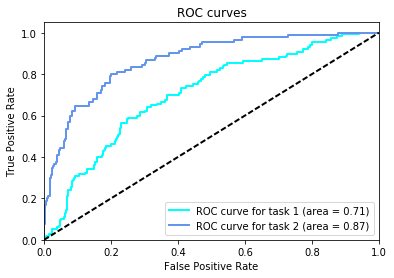

Category 1 Score: 0.706
Category 2 Score: 0.868
Category 3 Score: 0.787


In [457]:
from get_results import get_ground_truth, plot_roc_auc, plot_confusion_matrix

y_true = get_ground_truth()

plot_roc_auc(y_true, test_predictions)

In [415]:
def step(x, threshold=0):
    return np.sign(np.sign(x-threshold)+1)

def minimum_cost_threshold(y_true, y_pred, costs=(1, 1)):
    '''
    Find the decision threshold that minimizes the cost of errors.
    
    costs=(false_positive_cost, false_negative_cost)
    '''
    def error(x, costs):
        return costs[0]*step(-x, 0.99) + costs[1]*step(x,0.99)
    costs = np.array(costs)
    costs = costs/np.sum(costs)
    min_cost = np.inf
    min_threshold = 0
    for threshold in np.arange(0, 1, 0.001):
        y_pred_bin = np.ceil(y_pred - threshold)
#         cost = np.abs(y_true - y_pred_bin)*np.apply_along_axis(lambda i: costs[i[0]], 0, y_true)
        cost = error(y_true-y_pred_bin, costs)
        if np.mean(cost) < min_cost:
#             print(cost[:10])
            min_cost = np.mean(cost)
            min_threshold = threshold
    return min_threshold

def plot_best_confusion_matrix(y_true, y_pred, costs=(1,1)):
    threshold = minimum_cost_threshold(y_true, y_pred, costs=costs)
    print('Best threshold: %0.2f' % threshold)
    plot_confusion_matrix(y_true, y_pred, threshold)

## Melanoma Confusion

Best threshold: 0.11


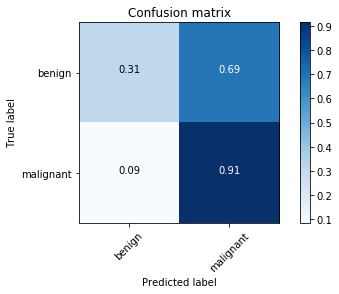

In [452]:
plot_best_confusion_matrix(y_true[:, 0], test_predictions[:, 0], costs=(1,10))

## Seborrheic Keratosis Confusion

Best threshold: 0.23


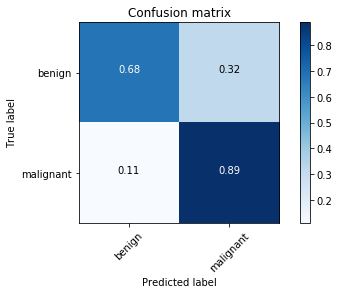

In [453]:
plot_best_confusion_matrix(y_true[:, 1], test_predictions[:, 1], costs=(1,10))